In [1]:
import yaml
import awkward as aw
import uproot
import hist
import math

from util import * 
import random
import time

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cloudpickle
import pickle

# Scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay,  classification_report
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, learning_curve, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

#XGBoost
import xgboost as xgb

# Scipy
from scipy.stats import ks_2samp
from scipy.stats import kstest


# Desactiva las advertencias (warnings)
import warnings
warnings.filterwarnings("ignore")

In [2]:
datasets = ['frvz_ggf_508885', 'frvz_ggf_508886', 'frvz_ggf_508887', 'frvz_ggf_508888', 'frvz_ggf_508889', 'frvz_ggf_508890', 'frvz_ggf_508891',
            'frvz_ggf_508892', 'frvz_ggf_508893', 'frvz_vbf_500757_02-00', 'frvz_vbf_500758_02-00',
            'frvz_vbf_500759_02-00', 'frvz_vbf_500760_02-00', 'frvz_vbf_500761_02-00', 'frvz_vbf_500762_02-00', 'frvz_vbf_500763_02-00', 'frvz_vbf_500764_02-00']

BDT_inputs = [
    #------------------ Escenciales los cortes originales ------------------------#
    'mjj', 'njet30', 'detajj', 'dphijj',# 'neleSignal', 'nmuSignal', 'hasBjet','metTrig',
    'MET', #'LJ1_type', 'LJmu1_isGood', 'LJmu1_centrality',
    #------------------- Variables para cálculo de weights ------------------------#
    "scale1fb", #cross section
    "intLumi", #luminosidad
    #"phiLJ",
    #"etaLJ",
    #"ptLJ",
   #------------------ Otras variables a gráfiar ------------------------# 
   
    "jet1_pt", "jet1_eta", "jet1_phi", "jet1_e", 
    #"jet2_pt", "jet2_eta", "jet2_phi", "jet2_e", 
    "signetajj",  #"dphi_j1met", "min_dphi_jetmet", 
    #"nLJ20","nLJjets20", "LJjet1_pt", "LJjet1_eta", "LJjet1_phi", "LJjet1_m", 
    #"LJjet1_width", "LJjet1_EMfrac", "LJjet1_timing", "LJjet1_jvt", "LJjet1_gapRatio", "LJjet1_BIBtagger", 
    #"LJjet1_DPJtagger", "LJjet1_truthDPidx", "nLJmus20",  
    "METsig", "METOSqrtHT", #"nLJmus20", 
    #"neleBaseline", "nmuBaseline", 
    #"hasBjet", "metTrig",
    #"LJjet1_isoID", "LJ1_type","LJjet1_timing",
    #"LJmu1_eta", "LJmu1_mu1DNNscore", "LJmu1_charge", "LJmu1_isoID",
            ]
df = read_data(datasets = datasets, variables=BDT_inputs, carpeta='C:/Users/jav90/Desktop/ing fisica/dpj/production_analysis/analisis_javier/Samples/')


frvz_ggf_508885
frvz_ggf_508886
frvz_ggf_508887
frvz_ggf_508888
frvz_ggf_508889
frvz_ggf_508890
frvz_ggf_508891
frvz_ggf_508892
frvz_ggf_508893
frvz_vbf_500757_02-00
frvz_vbf_500758_02-00
frvz_vbf_500759_02-00
frvz_vbf_500760_02-00
frvz_vbf_500761_02-00
frvz_vbf_500762_02-00
frvz_vbf_500763_02-00
frvz_vbf_500764_02-00


In [3]:
df.shape

(4628576, 16)

# Preprocesamiento de los datos

In [4]:
df1 = df.copy()
df1 = df1[df1['weights'] >= 0] #eliminar weights negativos y ceros
df1['VBF label'] = df1['tipo'].apply(lambda x: 1 if x == 'vbf' else 0) #crear columna con 1 para vbf y 0 para ggf

ml_var = [
    #------------------ Escenciales los cortes originales ------------------------#
    #'mjj',
    #'njet30', 
    'detajj', 
    #'dphijj',# 'neleSignal', 'nmuSignal', 'hasBjet','metTrig',
    'MET', #'LJ1_type', 'LJmu1_isGood', 'LJmu1_centrality',
    #------------------- Variables para cálculo de weights ------------------------#
    #"scale1fb", #cross section
    #"intLumi", #luminosidad
  #"phiLJ",
   # "etaLJ",
   # "ptLJ",
   #------------------ Otras variables a gráfiar ------------------------# 
   
  "jet1_pt", "jet1_eta", #"jet1_phi", 
  #"jet1_e", 
  #"jet2_pt",
    #"jet2_eta", 
   # "jet2_phi", #"jet2_e", 
   #"signetajj",  #"dphi_j1met", "min_dphi_jetmet", 
    #"nLJ20","nLJjets20", "LJjet1_pt", "LJjet1_eta", "LJjet1_phi", "LJjet1_m", 
    #"LJjet1_width", "LJjet1_EMfrac", "LJjet1_timing", "LJjet1_jvt", "LJjet1_gapRatio", "LJjet1_BIBtagger", 
    #"LJjet1_DPJtagger", "LJjet1_truthDPidx", "nLJmus20",  
    #"METsig", 
   # "METOSqrtHT", #"nLJmus20", 
    #"neleBaseline", "nmuBaseline", 
    #"hasBjet", "metTrig",
    #"LJjet1_isoID", "LJ1_type","LJjet1_timing",
    #"LJmu1_eta", "LJmu1_mu1DNNscore", "LJmu1_charge", "LJmu1_isoID",
            ]

# Separo ggF y VBF para realizar los cortes
X_ggf = df1[df1['tipo'] == 'ggf']
#X_ggf = X_ggf[X_ggf['mjj']< 900000] #cortes de ggF mjj < 900000
X_ggf_sampled = X_ggf.sample(n=84000, random_state=228) #Datos de ggF que se usarán para entrenar el modelo
not_sampled_ggf = X_ggf.drop(X_ggf_sampled.index)

X_vbf = df1[df1['tipo'] == 'vbf']
print(X_vbf.shape)
#X_vbf = X_vbf[X_vbf['njet30'] > 1] #cortes de VBF njets30 > 1
print(X_vbf.shape)
#X_vbf = X_vbf[X_vbf['mjj'] >= 900000] #cortes de VBF mjj > 900000
print(X_vbf.shape)
X_ggf_vbf = pd.concat([X_ggf_sampled, X_vbf], axis=0) #Datos de ggF y VBF que se usarán para entrenar el modelo
# X_ggf_vbf = X_ggf_vbf[X_ggf_vbf["mjj"] > 90000]
X_ggf_vbf_completo = pd.concat([X_ggf, X_vbf], axis=0) #Datos de ggF y VBF que se usarán para evaluar el modelo con todos los datos
#X_ggf_vbf_completo = X_ggf_vbf_completo[X_ggf_vbf_completo['mjj'] >= 900000] #cortes de VBF mjj > 900000


(491044, 17)
(491044, 17)
(491044, 17)


In [5]:
print(X_ggf_sampled.shape)
print(X_vbf.shape)

(84000, 17)
(491044, 17)


Distribución de eventos inciales (con corte de weights >= 0)

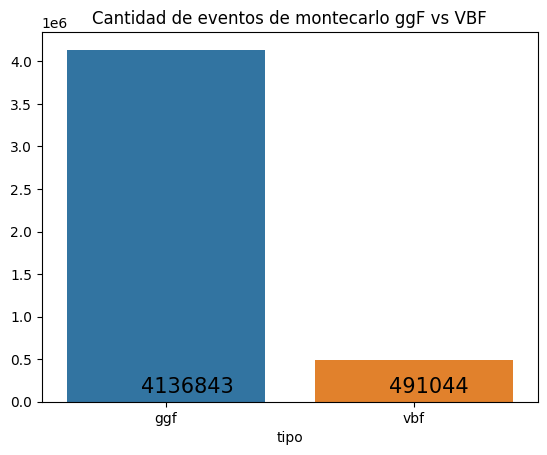

In [6]:
sns.barplot(x=X_ggf_vbf_completo['tipo'].value_counts().index, y=X_ggf_vbf_completo['tipo'] .value_counts().values)
plt.title('Cantidad de eventos de montecarlo ggF vs VBF')   
plt.text(-0.1, 100000, X_ggf_vbf_completo['tipo'].value_counts().values[0], fontsize=15)    
plt.text(0.9, 100000, X_ggf_vbf_completo['tipo'].value_counts().values[1], fontsize=15) 
plt.show()  

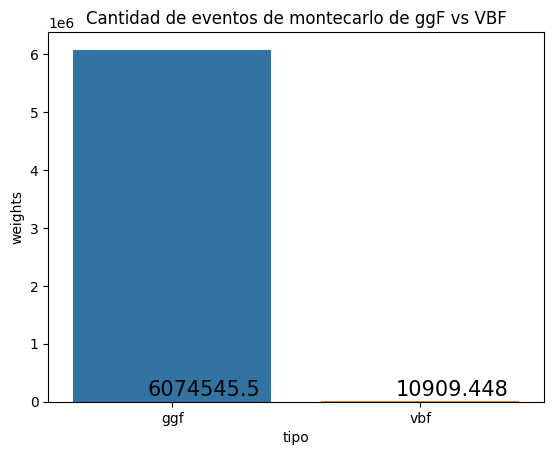

In [7]:
#X_ggf_vbf_completo = X_ggf_vbf_completo[X_ggf_vbf_completo["mjj"] > 900000]
sum_weights = X_ggf_vbf_completo.groupby('tipo')['weights'].sum().reset_index()

# Creamos el barplot
sns.barplot(x='tipo', y='weights', data=sum_weights)
plt.title('Cantidad de eventos de montecarlo de ggF vs VBF')
plt.text(0.9, 100000, X_ggf_vbf_completo[X_ggf_vbf_completo['tipo'] == 'vbf']["weights"].sum(), fontsize=15)
plt.text(-0.1, 100000, X_ggf_vbf_completo[X_ggf_vbf_completo['tipo'] == 'ggf']["weights"].sum(), fontsize=15)
plt.show()  

In [8]:
print(X_ggf_vbf[X_ggf_vbf["tipo"] == "vbf"]["weights"].sum())
print(X_ggf_vbf[X_ggf_vbf["tipo"] == "ggf"]["weights"].sum())

10909.448
123492.76


Distribución de eventos para el entrenamiento y test del modelo

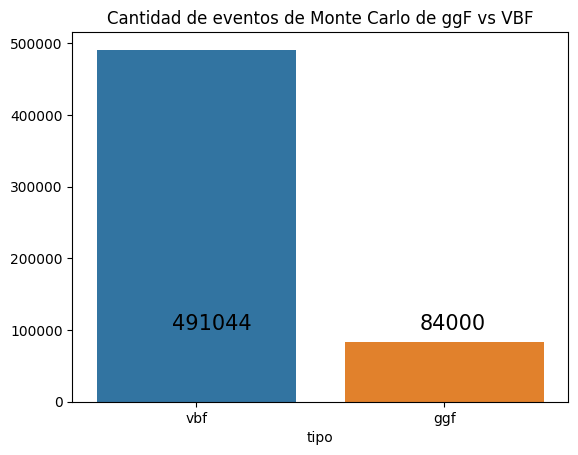

In [9]:
#X_ggf_vbf = X_ggf_vbf[X_ggf_vbf["mjj"] > 900000]
sns.barplot(x=X_ggf_vbf['tipo'].value_counts().index, y=X_ggf_vbf['tipo'].value_counts().values)
plt.title('Cantidad de eventos de Monte Carlo de ggF vs VBF')
plt.text(-0.1, 100000, X_ggf_vbf['tipo'].value_counts().values[0], fontsize=15)
plt.text(0.9, 100000, X_ggf_vbf['tipo'].value_counts().values[1], fontsize=15)
plt.show()  

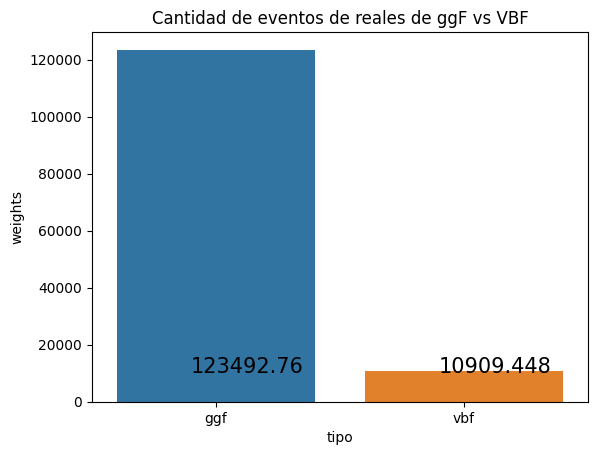

In [10]:
#X_ggf_vbf = X_ggf_vbf[X_ggf_vbf["mjj"] > 900000]
sum_weights = X_ggf_vbf.groupby('tipo')['weights'].sum().reset_index()

# Creamos el barplot
sns.barplot(x='tipo', y='weights', data=sum_weights)
plt.title('Cantidad de eventos de reales de ggF vs VBF')
plt.text(0.9, 10000, X_ggf_vbf[X_ggf_vbf['tipo'] == 'vbf']["weights"].sum(), fontsize=15)
plt.text(-0.1, 10000, X_ggf_vbf[X_ggf_vbf['tipo'] == 'ggf']["weights"].sum(), fontsize=15)
plt.show()  

# Entrenamiento

In [11]:
weights = X_ggf_vbf['weights'].copy()

X = X_ggf_vbf[ml_var].copy()

y = X_ggf_vbf['VBF label']

In [12]:
# X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=228)
# X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=228)

# scaler_train = StandardScaler().fit(X_train)
# X_train = pd.DataFrame(scaler_train.transform(X_train), columns = X_train.columns)

# #scaler_val = StandardScaler().fit(X_val)
# X_val = pd.DataFrame(scaler_train.transform(X_val), columns = X_train.columns)

# #scaler_test = StandardScaler().fit(X_test)
# X_test = pd.DataFrame(scaler_train.transform(X_test), columns = X_train.columns)

In [13]:
# Separar los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_val_test, y_train, y_val_test, weights_train, weights_val_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=228)

X_val, X_test, y_val, y_test, weights_val, weights_test = train_test_split(
    X_val_test, y_val_test, weights_val_test, test_size=0.5, random_state=228)

# Estandarizar los datos de entrenamiento y aplicar la misma transformación a los datos de validación y prueba
scaler_train = StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler_train.transform(X_train), columns=X.columns)
X_val = pd.DataFrame(scaler_train.transform(X_val), columns=X.columns)
X_test = pd.DataFrame(scaler_train.transform(X_test), columns=X.columns)

# Ahora puedes entrenar tu modelo con X_train, y_train y weights_train
# Además, puedes evaluar tu modelo con X_val, y_val y weights_val


In [14]:
params = { "n_estimators":25, 
            "max_depth": 8,
            "learning_rate": 0.3,
            "gamma": 0., #min loss reduction required to make a further partition on a leaf node of the tree
            "alpha": 0., #L1 regularization, mientras mayor es mas conservador
            "min_child_weight": 1, #min sum of weights of all observations required in a child
            "reg_lambda":1,  # L2 regularization, mientras mayor es mas conservador	

            "eval_metric": ["logloss", "auc", "error"],
            "early_stopping_rounds": 5, # Para evitar overfitting
            #"objective":"count:poisson",
            #"objective":"binary:hinge",
            "objective":"binary:logistic",
            "booster": "gbtree",
            "scale_pos_weight": 5.5,
            "verbosity": 1
            }

model = xgb.XGBClassifier(**params, tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)

In [15]:
X_not_sampled_ggf = not_sampled_ggf[ml_var]
X_not_sampled_ggf = pd.DataFrame(scaler_train.transform(X_not_sampled_ggf), columns = X_not_sampled_ggf.columns)
y_not_sampled_ggf = not_sampled_ggf['VBF label']

In [16]:
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True, sample_weight=weights_train)

train_predict = model.predict(X_train)

test_predict = model.predict(X_test)
test_predict2 = model.predict(pd.concat([X_test, X_not_sampled_ggf])) #predicción con todos los datos de ggF


[0]	validation_0-logloss:0.48647	validation_0-auc:0.98804	validation_0-error:0.07119
[1]	validation_0-logloss:0.37253	validation_0-auc:0.98880	validation_0-error:0.06631
[2]	validation_0-logloss:0.30152	validation_0-auc:0.98915	validation_0-error:0.06485
[3]	validation_0-logloss:0.25500	validation_0-auc:0.98927	validation_0-error:0.06332
[4]	validation_0-logloss:0.22355	validation_0-auc:0.98936	validation_0-error:0.06268
[5]	validation_0-logloss:0.20185	validation_0-auc:0.98942	validation_0-error:0.06280
[6]	validation_0-logloss:0.18654	validation_0-auc:0.98937	validation_0-error:0.06227
[7]	validation_0-logloss:0.17603	validation_0-auc:0.98935	validation_0-error:0.06231
[8]	validation_0-logloss:0.16860	validation_0-auc:0.98939	validation_0-error:0.06168
[9]	validation_0-logloss:0.16337	validation_0-auc:0.98938	validation_0-error:0.06149
[10]	validation_0-logloss:0.15972	validation_0-auc:0.98940	validation_0-error:0.06122
[11]	validation_0-logloss:0.15714	validation_0-auc:0.98942	valid

In [17]:

test_accuracy = accuracy_score(y_test, test_predict)
print("Test accuracy", test_accuracy)

Test accuracy 0.9399932759080423


# Resultados

Matriz de confusión

In [18]:
weights_test

1554728    1.691023
4311338    0.014399
4366208    0.014618
412612     1.746603
4495845    0.042100
             ...   
4562116    0.024187
4197395    0.024066
4206941    0.028637
4219322    0.032658
112777     1.675924
Name: weights, Length: 86257, dtype: float32

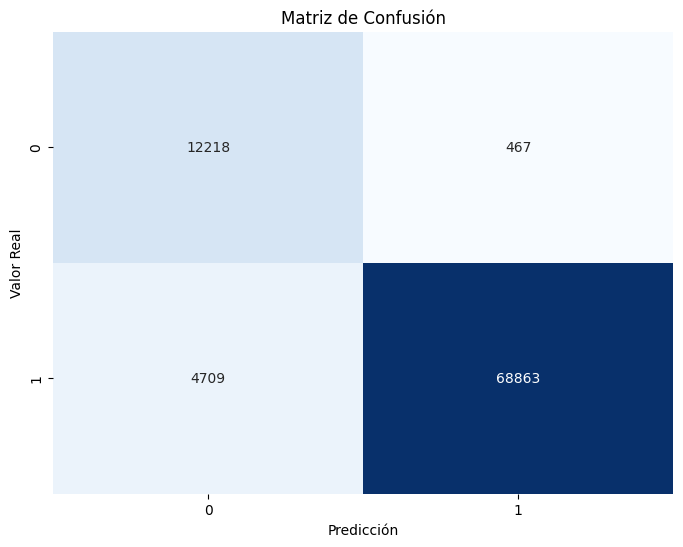

In [19]:
cm = confusion_matrix(y_test, test_predict)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

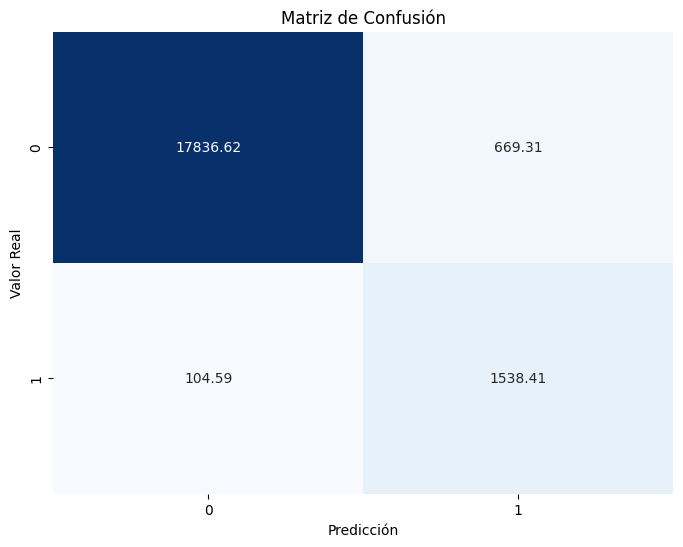

In [20]:
# Calcula la matriz de confusión usando los pesos
cmw = confusion_matrix(y_test, test_predict, sample_weight=weights_test)

# Visualiza la matriz de confusión con pesos
plt.figure(figsize=(8, 6))
sns.heatmap(cmw, annot=True, fmt=".2f", cmap="Blues", cbar=False)  # Aquí usamos .2f para formatear flotantes
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()


Matriz de confusión con todos los datos de ggF

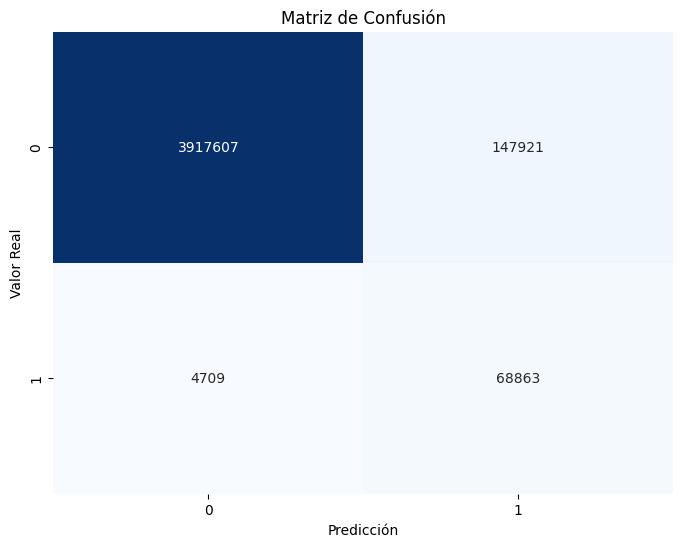

In [21]:
cm2 = confusion_matrix(pd.concat([y_test,y_not_sampled_ggf]), test_predict2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

Clasificación de ggF y VBF

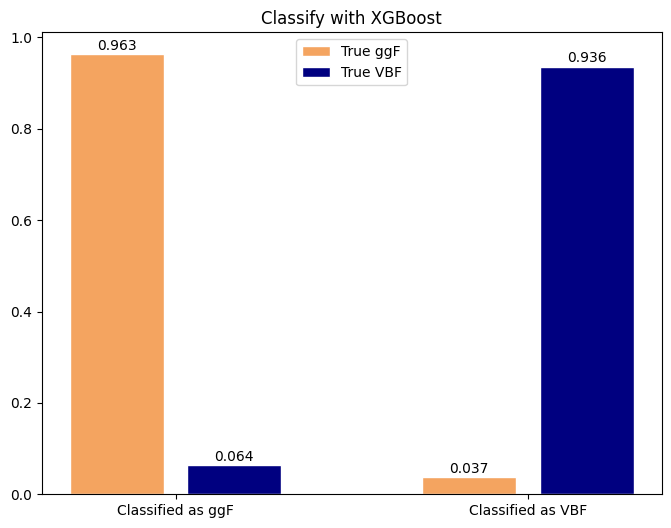

In [22]:
ggf_as_ggf = cm[0,0]
ggf_as_vbf = cm[0,1]
vbf_as_ggf = cm[1,0]
vbf_as_vbf = cm[1,1]
bars1 = np.array([ggf_as_ggf, ggf_as_vbf]) / (ggf_as_ggf+ggf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'ggf'].shape[0])
bars2 = np.array([vbf_as_ggf, vbf_as_vbf]) / (vbf_as_ggf+vbf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'vbf'].shape[0])
pos1 = [0,3]
pos2 = [1,4]
plt.figure(figsize=(8, 6))
plt.bar(pos1, bars1, width=.8, color='sandybrown', edgecolor='white', label='True ggF')
plt.bar(pos2, bars2, width=.8, color="navy", edgecolor='white', label='True VBF')
plt.xticks([.5,3.5] ,['Classified as ggF','Classified as VBF'])

for i in range(2):
     plt.text(pos1[i], bars1[i] + 0.01, str(round(bars1[i],3)), ha='center')
     plt.text(pos2[i], bars2[i] + 0.01, str(round(bars2[i],3)), ha='center')
plt.title("Classify with XGBoost")
plt.legend(loc='upper center')

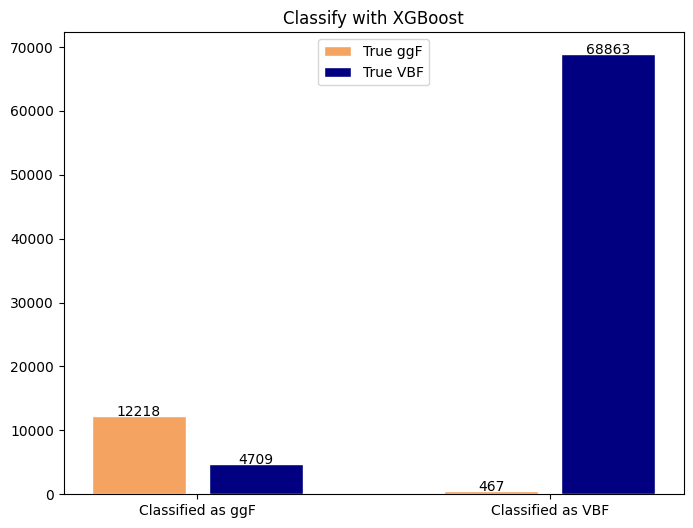

In [147]:
ggf_as_ggf = cm[0,0]
ggf_as_vbf = cm[0,1]
vbf_as_ggf = cm[1,0]
vbf_as_vbf = cm[1,1]
bars1 = np.array([ggf_as_ggf, ggf_as_vbf])#+df_not_used[df_not_used['tipo'] == 'ggf'].shape[0])
bars2 = np.array([vbf_as_ggf, vbf_as_vbf])#+df_not_used[df_not_used['tipo'] == 'vbf'].shape[0])
pos1 = [0,3]
pos2 = [1,4]
plt.figure(figsize=(8, 6))
plt.bar(pos1, bars1, width=.8, color='sandybrown', edgecolor='white', label='True ggF')
plt.bar(pos2, bars2, width=.8, color="navy", edgecolor='white', label='True VBF')
plt.xticks([.5,3.5] ,['Classified as ggF','Classified as VBF'])

for i in range(2):
     plt.text(pos1[i], bars1[i] + 0.01, str(round(bars1[i],3)), ha='center')
     plt.text(pos2[i], bars2[i] + 0.01, str(round(bars2[i],3)), ha='center')
plt.title("Classify with XGBoost")
plt.legend(loc='upper center')

Clasiciación de ggF y VBF usando todos los datos de ggF

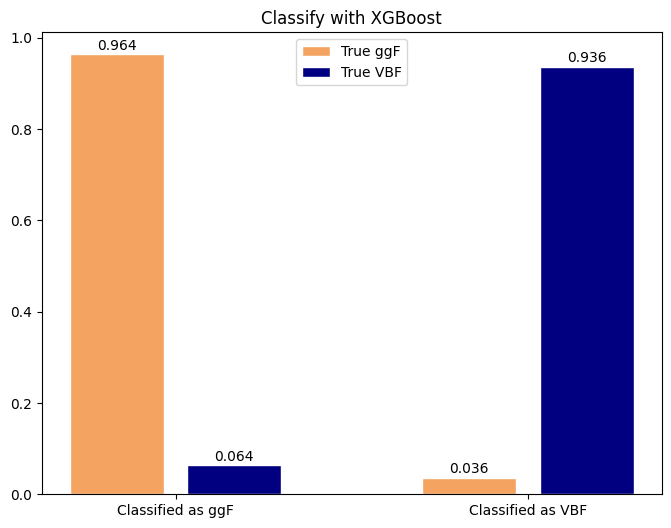

In [148]:
ggf_as_ggf = cm2[0,0]
ggf_as_vbf = cm2[0,1]
vbf_as_ggf = cm2[1,0]
vbf_as_vbf = cm2[1,1]
bars1 = np.array([ggf_as_ggf, ggf_as_vbf]) / (ggf_as_ggf+ggf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'ggf'].shape[0])
bars2 = np.array([vbf_as_ggf, vbf_as_vbf]) / (vbf_as_ggf+vbf_as_vbf)#+df_not_used[df_not_used['tipo'] == 'vbf'].shape[0])
pos1 = [0,3]
pos2 = [1,4]
plt.figure(figsize=(8, 6))
plt.bar(pos1, bars1, width=.8, color='sandybrown', edgecolor='white', label='True ggF')
plt.bar(pos2, bars2, width=.8, color="navy", edgecolor='white', label='True VBF')
plt.xticks([.5,3.5] ,['Classified as ggF','Classified as VBF'])

for i in range(2):
     plt.text(pos1[i], bars1[i] + 0.01, str(round(bars1[i],3)), ha='center')
     plt.text(pos2[i], bars2[i] + 0.01, str(round(bars2[i],3)), ha='center')
plt.title("Classify with XGBoost")
plt.legend(loc='upper center')

In [149]:
print(classification_report(y_test, test_predict))
print(classification_report(pd.concat([y_test,y_not_sampled_ggf]), test_predict2))

              precision    recall  f1-score   support

           0       0.72      0.96      0.83     12685
           1       0.99      0.94      0.96     73572

    accuracy                           0.94     86257
   macro avg       0.86      0.95      0.89     86257
weighted avg       0.95      0.94      0.94     86257

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   4065528
           1       0.32      0.94      0.47     73572

    accuracy                           0.96   4139100
   macro avg       0.66      0.95      0.73   4139100
weighted avg       0.99      0.96      0.97   4139100



### Klomogorov-Smirnov Test

### Matriz de correlación

Text(0.5, 1.0, 'Matriz de correlación, variables de entrenamiento')

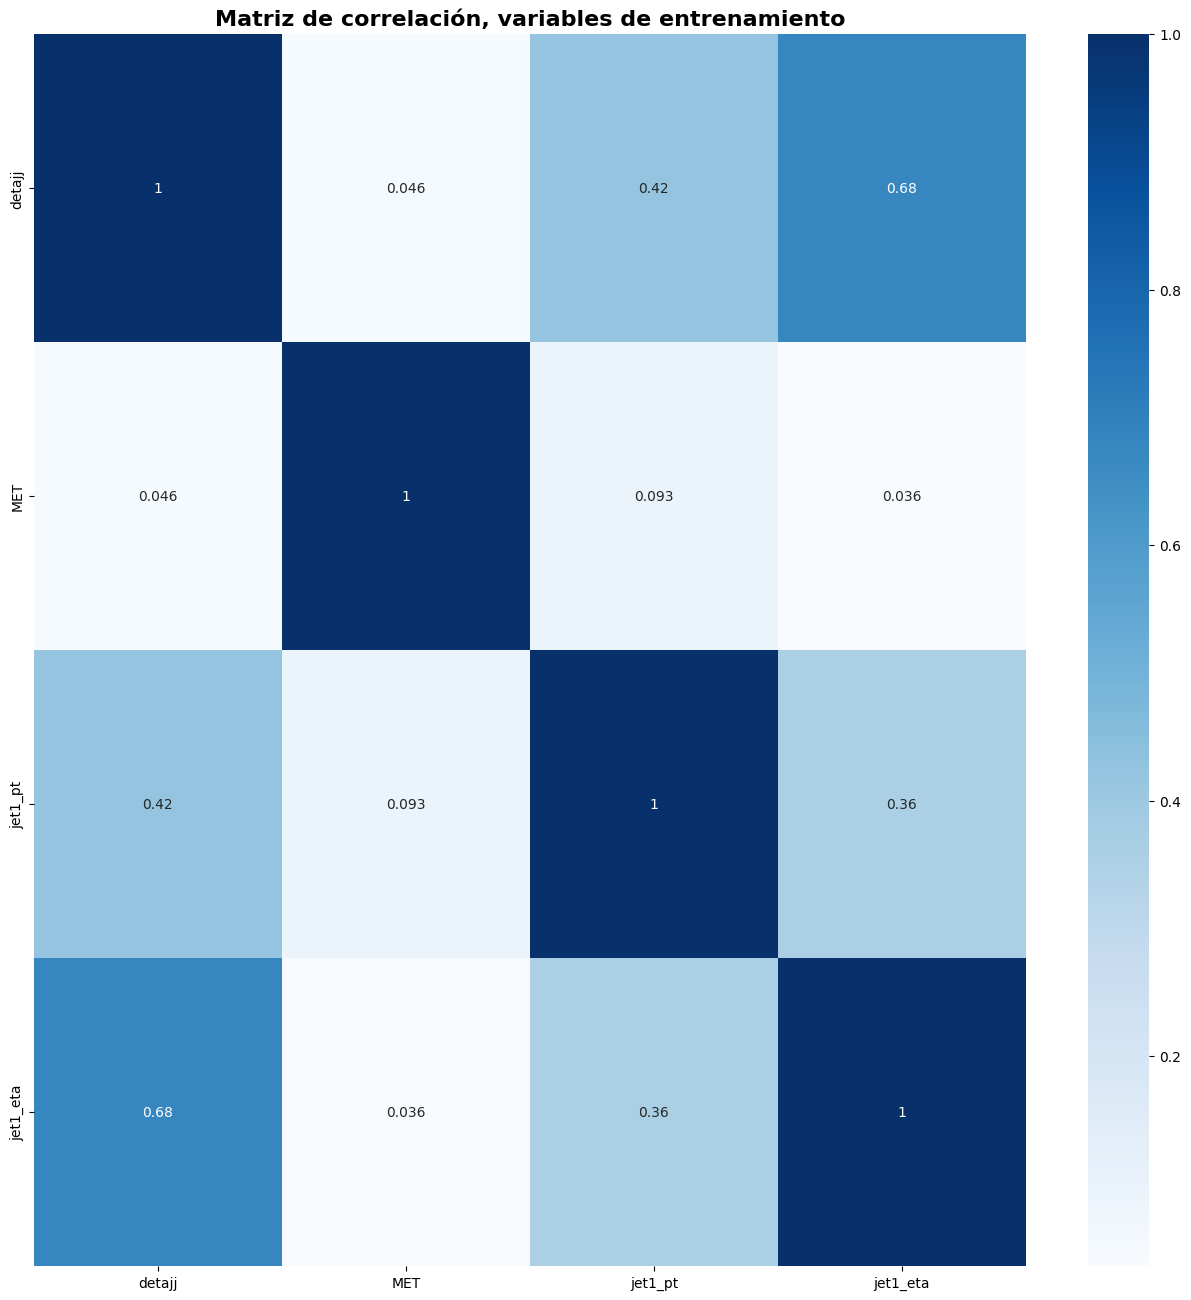

In [150]:
fig, ax = plt.subplots(figsize=(16, 16))

sns.heatmap(X_train.corr().abs().map(lambda x: round(x,5)), cmap='Blues', annot=True)
plt.title("Matriz de correlación, variables de entrenamiento", fontsize=16, fontdict={"weight": "bold"})

### Importancia de cada atributo de la matriz de atributos en el modelo

Importancia de características:
detajj: 0.8119035363197327
jet1_pt: 0.15282322466373444
jet1_eta: 0.020943548530340195
MET: 0.014329688623547554


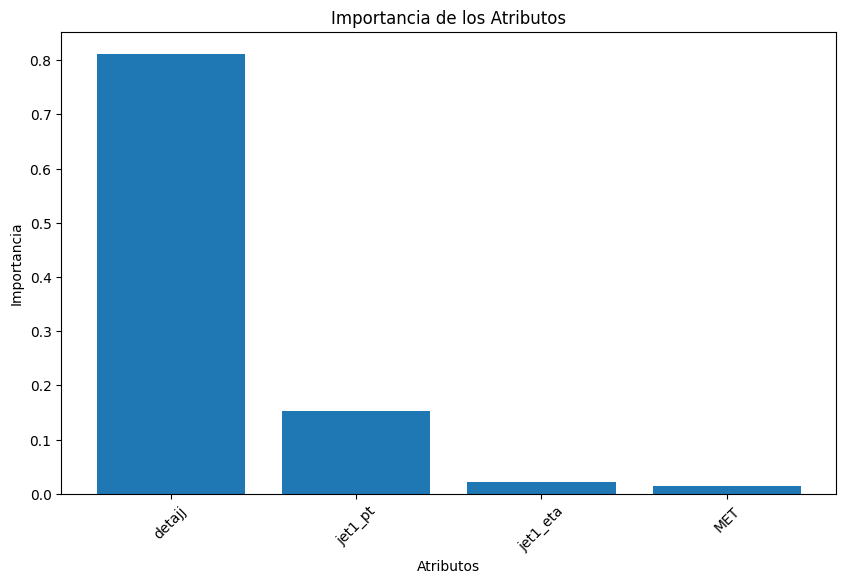

In [151]:
# Obtén la importancia de las características
feature_importance = model.feature_importances_

# Ordena las características por importancia descendente
sorted_idx = feature_importance.argsort()[::-1]

# Imprime las importancias de las características
print("Importancia de características:")
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {feature_importance[i]}")

# Crea el scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_importance)), X_train.columns[sorted_idx], rotation=45)
plt.xlabel("Atributos")
plt.ylabel("Importancia")
plt.title("Importancia de los Atributos")
plt.show()


In [152]:
# import factor_analyzer as fact

# fact.calculate_bartlett_sphericity(X_train)
# fact.calculate_kmo(X_train)
# # Generamos una nueva instancia en el objeto factorize e implementamos el análisis
# factorize = fact.FactorAnalyzer(n_factors=10, rotation= None)
# factorize.fit(X_train)
# # extraemos los eigenvalues
# factor_screeplot = factorize.get_eigenvalues()[0]
# # graficamos los eigenvalues contra la cantidad de dimensiones estimables
# plt.plot(range(len(factor_screeplot)), factor_screeplot, 'o-', color='tomato')
# plt.xlabel('Número de Factor')
# plt.ylabel('Valores Propios')
# # visualizamos el criterio de corte
# plt.axhline(1)
# plt.title("Scree plot")

In [153]:

# # Realizar la validación cruzada
# dtrain = xgb.DMatrix(X_train, label=y_train)
# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=1000,
#     nfold=5,
#     early_stopping_rounds=10,
#     verbose_eval=True,
# )

# # Graficar los resultados de la validación cruzada
# # plt.figure(figsize=(10, 6))
# # plt.plot(cv_results['train-rmse-mean'], label='Training RMSE')
# # plt.plot(cv_results['test-rmse-mean'], label='Validation RMSE')
# # plt.xlabel('Número de rondas de refuerzo')
# # plt.ylabel('RMSE')
# # plt.title('Cross Validation Plot')
# plt.legend()
# plt.show()

In [154]:
# plt.plot(cv_results["test-auc-mean"], label="test")
# plt.plot(cv_results["train-auc-mean"], label="train")
# plt.legend()
# plt.ylabel("AUC")
# plt.xlabel("Ronda")
# plt.title("AUC")
# plt.show()

#### Curva ROC

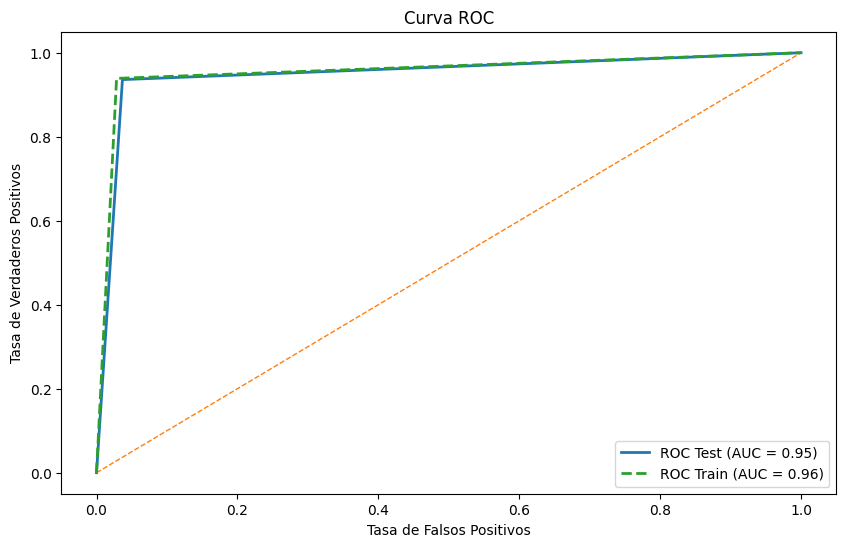

In [155]:
from sklearn.metrics import roc_curve, auc
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, test_predict)
false_positive2, true_positive2, threshold2 = roc_curve(y_train, train_predict)
roc_auc = auc(false_positive, true_positive)
roc_auc2 = auc(false_positive2, true_positive2)

plt.figure(figsize=(10, 6))

# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=2,  label='ROC Test (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], ls="--", lw=1)
plt.plot(false_positive2, true_positive2, lw=2, ls= "--",label='ROC Train (AUC = {:.2f})'.format(roc_auc2))


#plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Tasa de Verdaderos Positivos')
plt.xlabel('Tasa de Falsos Positivos')
plt.legend()
plt.show()

#### Métricas de Cross Validation

#### Learning curve

In [156]:

model2 = xgb.XGBClassifier(**params)

train_sizes, train_scores, test_scores = learning_curve(model2, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.001, 1.0, 10), fit_params={'eval_set': eval_set})

[0]	validation_0-logloss:0.45837	validation_0-auc:0.97852	validation_0-error:0.03375
[1]	validation_0-logloss:0.33053	validation_0-auc:0.97940	validation_0-error:0.03360
[2]	validation_0-logloss:0.25149	validation_0-auc:0.98214	validation_0-error:0.03304
[3]	validation_0-logloss:0.19963	validation_0-auc:0.98250	validation_0-error:0.03196
[4]	validation_0-logloss:0.16483	validation_0-auc:0.98284	validation_0-error:0.03181
[5]	validation_0-logloss:0.14090	validation_0-auc:0.98582	validation_0-error:0.03155
[6]	validation_0-logloss:0.12447	validation_0-auc:0.98745	validation_0-error:0.03135
[7]	validation_0-logloss:0.11322	validation_0-auc:0.98758	validation_0-error:0.03093
[8]	validation_0-logloss:0.10555	validation_0-auc:0.98757	validation_0-error:0.03094
[9]	validation_0-logloss:0.10023	validation_0-auc:0.98756	validation_0-error:0.03054
[10]	validation_0-logloss:0.09668	validation_0-auc:0.98760	validation_0-error:0.03057
[11]	validation_0-logloss:0.09442	validation_0-auc:0.98777	valid

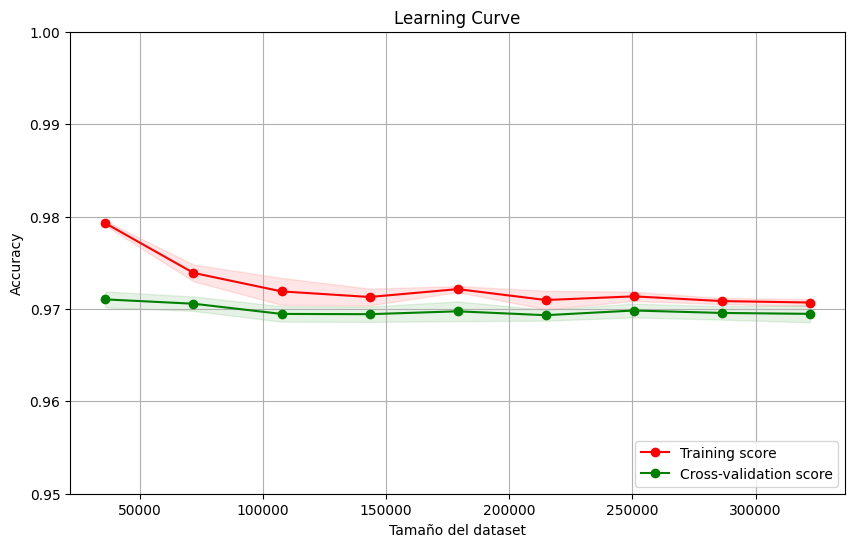

In [157]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

plt.title("Learning Curve")
plt.xlabel("Tamaño del dataset")
plt.ylabel("Accuracy")
plt.ylim(.95, 1)
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [158]:
# eval_set = [(X_val, y_val)]

# model = xgb.XGBClassifier(**params)
# train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_log_loss', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42, shuffle=True, verbose=1, fit_params={'eval_set': eval_set})


# train_scores_mean = -np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = -np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.figure(figsize=(10, 6))
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
# plt.xlabel("Training examples")
# plt.ylabel("Negative Log Loss")
# plt.legend(loc="best")
# plt.show()


In [159]:
model2 = xgb.XGBClassifier(**params)

[0]	validation_0-logloss:0.45807	validation_0-auc:0.98468	validation_0-error:0.03330
[1]	validation_0-logloss:0.32984	validation_0-auc:0.98725	validation_0-error:0.03174
[2]	validation_0-logloss:0.25079	validation_0-auc:0.98796	validation_0-error:0.03178
[3]	validation_0-logloss:0.19918	validation_0-auc:0.98810	validation_0-error:0.03196
[4]	validation_0-logloss:0.16446	validation_0-auc:0.98885	validation_0-error:0.03180
[5]	validation_0-logloss:0.14052	validation_0-auc:0.98896	validation_0-error:0.03192
[6]	validation_0-logloss:0.12422	validation_0-auc:0.98905	validation_0-error:0.03215
[0]	validation_0-logloss:0.45813	validation_0-auc:0.98340	validation_0-error:0.03363
[1]	validation_0-logloss:0.32992	validation_0-auc:0.98673	validation_0-error:0.03247
[2]	validation_0-logloss:0.25072	validation_0-auc:0.98776	validation_0-error:0.03178
[3]	validation_0-logloss:0.19902	validation_0-auc:0.98785	validation_0-error:0.03178
[4]	validation_0-logloss:0.16432	validation_0-auc:0.98840	validat

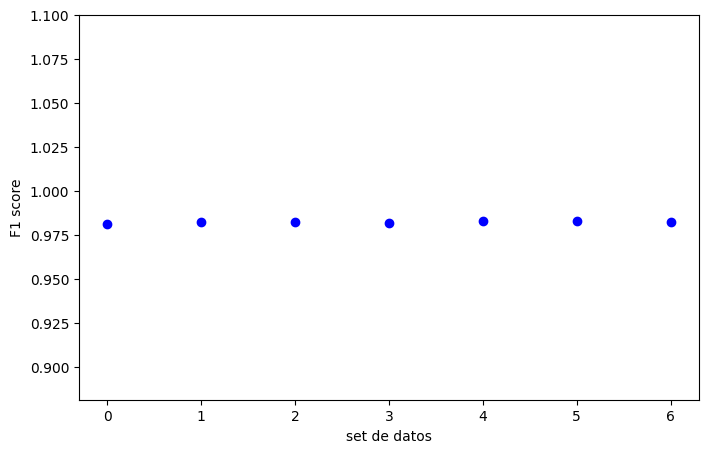

In [160]:
eval_set = [(X_val, y_val)]
cv_scores = cross_val_score(model2, X_train, y_train, cv=7, scoring='f1', fit_params={'eval_set': eval_set})


plt.figure(figsize=[8, 5])

plt.scatter(range(0,7),cv_scores, color = "blue")
plt.xlabel("set de datos")
plt.ylabel("F1 score")
plt.ylim([cv_scores[0]-.1, 1.1])


plt.show()


[0]	validation_0-logloss:0.45807	validation_0-auc:0.98468	validation_0-error:0.03330
[1]	validation_0-logloss:0.32984	validation_0-auc:0.98725	validation_0-error:0.03174
[2]	validation_0-logloss:0.25079	validation_0-auc:0.98796	validation_0-error:0.03178
[3]	validation_0-logloss:0.19918	validation_0-auc:0.98810	validation_0-error:0.03196
[4]	validation_0-logloss:0.16446	validation_0-auc:0.98885	validation_0-error:0.03180
[5]	validation_0-logloss:0.14052	validation_0-auc:0.98896	validation_0-error:0.03192
[6]	validation_0-logloss:0.12422	validation_0-auc:0.98905	validation_0-error:0.03215
[0]	validation_0-logloss:0.45813	validation_0-auc:0.98340	validation_0-error:0.03363
[1]	validation_0-logloss:0.32992	validation_0-auc:0.98673	validation_0-error:0.03247
[2]	validation_0-logloss:0.25072	validation_0-auc:0.98776	validation_0-error:0.03178
[3]	validation_0-logloss:0.19902	validation_0-auc:0.98785	validation_0-error:0.03178
[4]	validation_0-logloss:0.16432	validation_0-auc:0.98840	validat

(0.8677593252760629, 1.1)

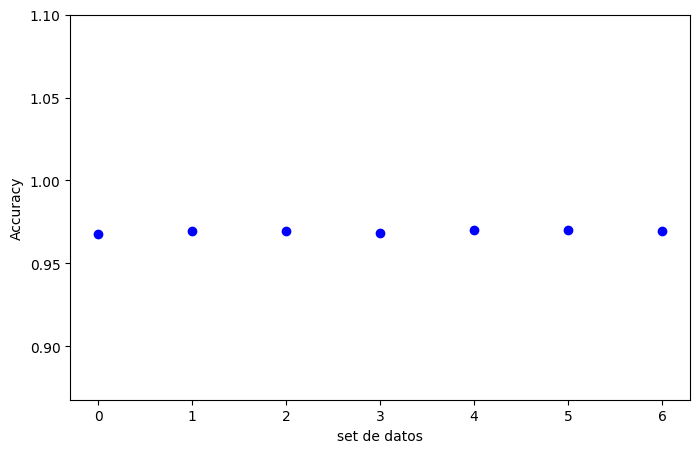

In [161]:
eval_set = [(X_val, y_val)]
cv_scores = cross_val_score(model2, X_train, y_train, cv=7, scoring='accuracy', fit_params={'eval_set': eval_set})

plt.figure(figsize=[8, 5])

plt.scatter(range(0,7),cv_scores, color = "blue")
plt.xlabel("set de datos")
plt.ylabel("Accuracy")
plt.ylim([cv_scores[0]-.1, 1.1])



[0]	validation_0-logloss:0.45807	validation_0-auc:0.98468	validation_0-error:0.03330
[1]	validation_0-logloss:0.32984	validation_0-auc:0.98725	validation_0-error:0.03174
[2]	validation_0-logloss:0.25079	validation_0-auc:0.98796	validation_0-error:0.03178
[3]	validation_0-logloss:0.19918	validation_0-auc:0.98810	validation_0-error:0.03196
[4]	validation_0-logloss:0.16446	validation_0-auc:0.98885	validation_0-error:0.03180
[5]	validation_0-logloss:0.14052	validation_0-auc:0.98896	validation_0-error:0.03192
[6]	validation_0-logloss:0.12422	validation_0-auc:0.98905	validation_0-error:0.03215
[0]	validation_0-logloss:0.45813	validation_0-auc:0.98340	validation_0-error:0.03363
[1]	validation_0-logloss:0.32992	validation_0-auc:0.98673	validation_0-error:0.03247
[2]	validation_0-logloss:0.25072	validation_0-auc:0.98776	validation_0-error:0.03178
[3]	validation_0-logloss:0.19902	validation_0-auc:0.98785	validation_0-error:0.03178
[4]	validation_0-logloss:0.16432	validation_0-auc:0.98840	validat

(0.8858072433764302, 1.1)

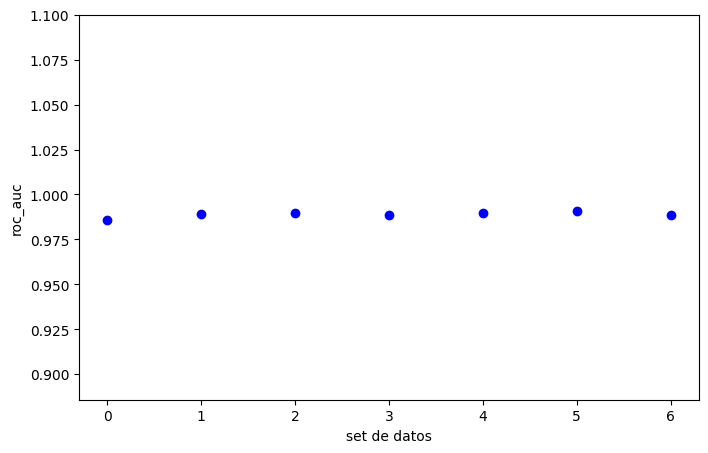

In [162]:
eval_set = [(X_val, y_val)]
cv_scores = cross_val_score(model2, X_train, y_train, cv=7, scoring='roc_auc', fit_params={'eval_set': eval_set})

plt.figure(figsize=[8, 5])

plt.scatter(range(0,7),cv_scores, color = "blue")
plt.xlabel("set de datos")
plt.ylabel("roc_auc")
plt.ylim([cv_scores[0]-.1, 1.1])



Distribución de probabilidad y Kolmogorov-Smirnov Test

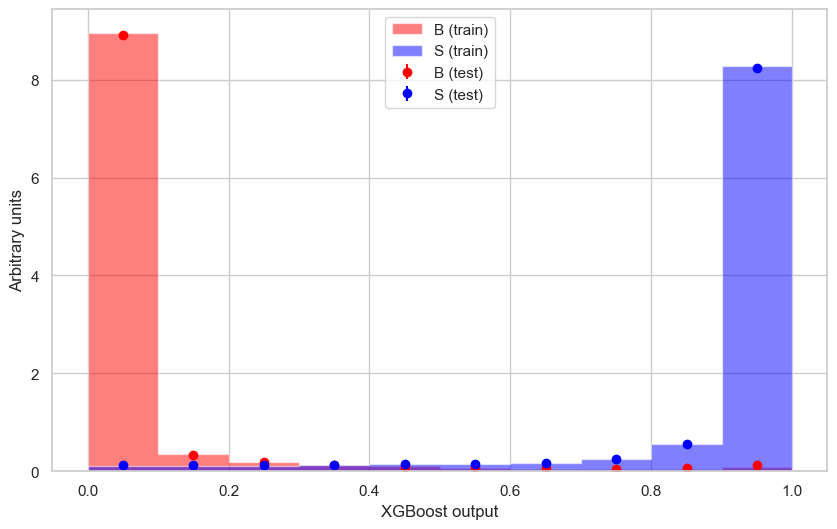

In [199]:
 # Overtraining Check
# A popular way in HEP to check overtraining is to output training and testing distributions (but there are others) and see the difference between them.

def compare_train_test(clf, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 6)) # create a figure object
    decisions = [] 
    for X, y in ((X_train, y_train), (X_test, y_test)):
        probas = clf.predict_proba(X)[:, 1]  # Obtener la probabilidad de la clase 1
        d1 = probas[y < 0.5].ravel()  # background
        d2 = probas[y > 0.5].ravel()  # signal
        decisions += [d1, d2]
    
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)

    # calculate de kolmogorov-smirnov test
    #ks = stats.ks_2samp(decisions[2], decisions[3]) # test statistic and p-value
    #plt.title("KS test: %.3f, p-value %.3f"%(ks[0], ks[1])) # add title

    plt.xlabel("XGBoost output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend(loc='upper center') # add legend
    
compare_train_test(model, X_train, y_train, X_test, y_test) # call compare_train_test

In [164]:
from scipy import stats

# Probabilidades de la clase positiva (usualmente señal)
probas_train_signal = model.predict_proba(X_train)[:, 1][y_train > 0.5].ravel()
probas_test_signal = model.predict_proba(X_test)[:, 1][y_test > 0.5].ravel()

# Prueba KS para la señal
ks_signal = stats.ks_2samp(probas_train_signal, probas_test_signal)
print("KS test Signal: %.3f, p-value %.3f" % (ks_signal.statistic, ks_signal.pvalue))

# Probabilidades de la clase negativa (usualmente fondo)
probas_train_background = model.predict_proba(X_train)[:, 1][y_train < 0.5].ravel()
probas_test_background = model.predict_proba(X_test)[:, 1][y_test < 0.5].ravel()

# Prueba KS para el fondo
ks_background = stats.ks_2samp(probas_train_background, probas_test_background)
print("KS test Background: %.3f, p-value %.3f" % (ks_background.statistic, ks_background.pvalue))


KS test Signal: 0.004, p-value 0.446
KS test Background: 0.009, p-value 0.406


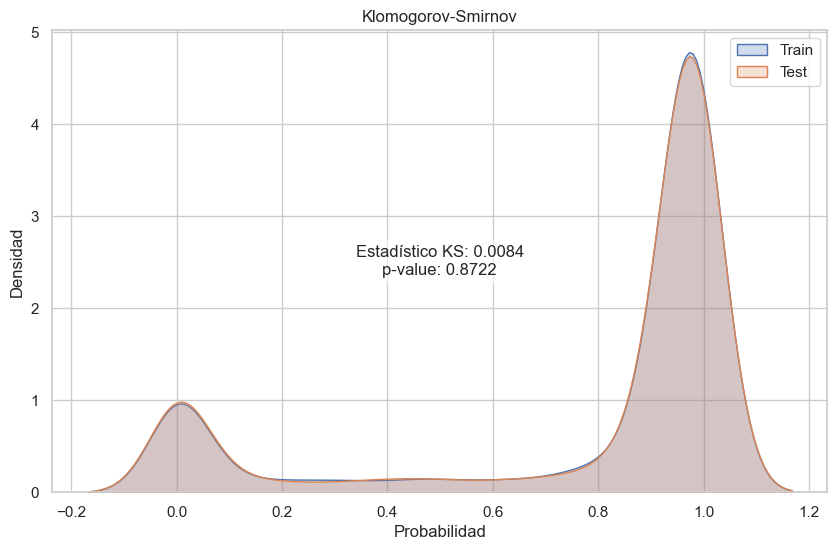

In [165]:
probs_train = model.predict_proba(X_train.sample(n=10000, random_state = 1228))[:, 1] 
probs_test = model.predict_proba(X_test.sample(n=10000,random_state=1228))[:, 1]    
ks_test, p_value = ks_2samp(probs_train, probs_test)


sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(probs_train, label="Train", shade=True)
sns.kdeplot(probs_test, label="Test", shade=True)

plt.title("Klomogorov-Smirnov")
plt.xlabel("Probabilidad")
plt.ylabel("Densidad")
plt.legend()
plt.text(0.5, 0.5, f"Estadístico KS: {ks_test:.4f}\np-value: {p_value:.4f}", 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


In [166]:
trees = model.get_booster().get_dump()
for i, tree_dump in enumerate(trees):
    print(f"Árbol {i + 1}:\n")
    print(tree_dump)
    print("\n" + "=" * 50 + "\n")

Árbol 1:

0:[detajj<0.313516825] yes=1,no=2,missing=2
	1:[jet1_pt<-0.325073332] yes=3,no=4,missing=4
		3:[MET<-0.00796254259] yes=7,no=8,missing=8
			7:[jet1_pt<-0.773332655] yes=15,no=16,missing=16
				15:[detajj<0.303186417] yes=31,no=32,missing=32
					31:leaf=-0.599745512
					32:[jet1_eta<0.232167348] yes=61,no=62,missing=62
						61:[jet1_eta<0.204725876] yes=117,no=118,missing=118
							117:[jet1_pt<-0.996885598] yes=217,no=218,missing=218
								217:leaf=-0.555335999
								218:leaf=-0.3856543
							118:[jet1_pt<-0.891036808] yes=219,no=220,missing=220
								219:leaf=-0.590464413
								220:leaf=-0.557832599
						62:[jet1_pt<-0.938989043] yes=119,no=120,missing=120
							119:[MET<-0.0245963782] yes=221,no=222,missing=222
								221:leaf=-0.512383401
								222:leaf=-0.110860147
							120:[MET<-0.0699713826] yes=223,no=224,missing=224
								223:leaf=-0.289079547
								224:leaf=0.097668834
				16:[jet1_eta<0.229246452] yes=33,no=34,missing=34
					33:[jet1_eta<0.2

# Crear variable ML discriminator

In [23]:
df["VBF label"] = df["tipo"].apply(lambda x: 1 if x == "vbf" else 0)

In [24]:
X_concat = pd.concat([X_ggf_vbf, not_sampled_ggf], axis=0)

In [25]:
y_concat = pd.concat([y_train, y_test, y_not_sampled_ggf])

In [26]:
y_pred_concat = pd.concat([pd.DataFrame({"ML Disciminator": train_predict}), pd.DataFrame({"ML Disciminator": test_predict2})])

In [27]:
y_predict_all = model.predict(pd.DataFrame(scaler_train.transform(X_ggf_vbf_completo[ml_var]), columns = X_train.columns))

In [28]:
# X_ggf_vbf_completo["ML Disciminator"] = y_predict_all
# X_ggf_vbf_completo["ML Disciminator probability"] = model.predict_proba(pd.DataFrame(scaler_train.transform(X_ggf_vbf_completo[ml_var]), columns = X_train.columns))[:, 1]

X_ggf_vbf["ML Disciminator"] = model.predict(pd.DataFrame(scaler_train.transform(X_ggf_vbf[ml_var]), columns = X_train.columns))
X_ggf_vbf["ML Disciminator probability"] = model.predict_proba(pd.DataFrame(scaler_train.transform(X_ggf_vbf[ml_var]), columns = X_train.columns))[:, 1]
X_ggf_vbf["label"] = y_test

In [29]:
X_ggf_vbf_completo["weights"].describe()

count    4.627887e+06
mean     1.314953e+00
std      7.598987e-01
min      0.000000e+00
25%      1.006510e+00
50%      1.536343e+00
75%      1.735400e+00
max      6.363682e+00
Name: weights, dtype: float64

In [30]:
X_ggf_vbf_completo["weights"]

0          1.730729
1          1.222444
2          1.492153
3          1.714360
4          1.521348
             ...   
4628571    0.009256
4628572    0.011002
4628573    0.000271
4628574    0.010165
4628575    0.011909
Name: weights, Length: 4627887, dtype: float32

In [31]:
y_test

1554728    0
4311338    1
4366208    1
412612     0
4495845    1
          ..
4562116    1
4197395    1
4206941    1
4219322    1
112777     0
Name: VBF label, Length: 86257, dtype: int64

In [32]:
X_test

,detajj,MET,jet1_pt,jet1_eta
0,-3.139617,-0.158320,-1.244849,0.202551
1,0.323872,0.072017,-0.119738,0.231645
2,0.323266,0.058530,-0.340737,0.202106
3,0.315257,-0.108984,-1.164999,0.220138
4,0.326787,0.190038,0.096401,0.233884
...,...,...,...,...
86252,0.314824,0.100086,0.822169,0.231116
86253,0.319335,-0.191930,0.379735,0.200723
86254,0.317864,0.026279,-0.200480,0.205532
86255,0.318574,0.138450,0.484075,0.204722


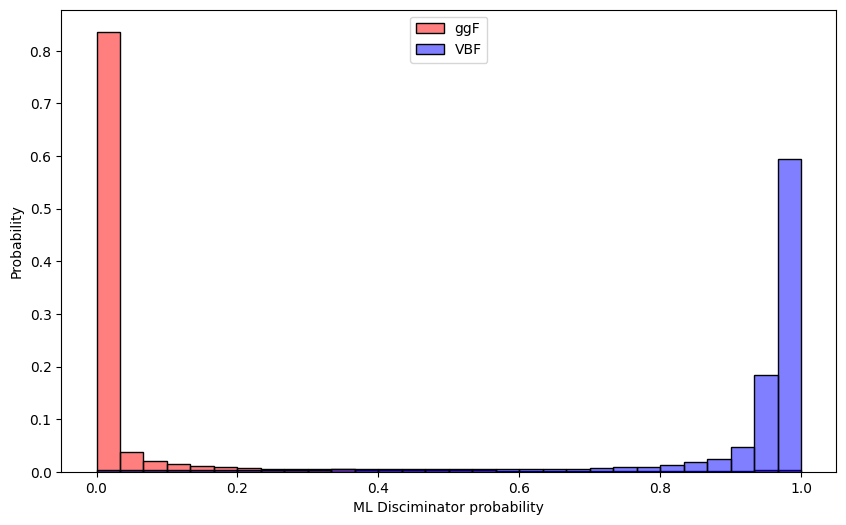

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(X_ggf_vbf[X_ggf_vbf["tipo"] == "ggf"]["ML Disciminator probability"], label="ggF", color="red", alpha=0.5, stat="probability", bins=30, binrange=(0,1))
sns.histplot(X_ggf_vbf[X_ggf_vbf["tipo"] == "vbf"]["ML Disciminator probability"], label="VBF", color="blue", alpha=0.5, stat="probability", bins=30, binrange=(0,1))
plt.legend(loc="upper center")

Text(0.5, 1.0, 'Distribución de probabilidad del discriminador ML con weights')

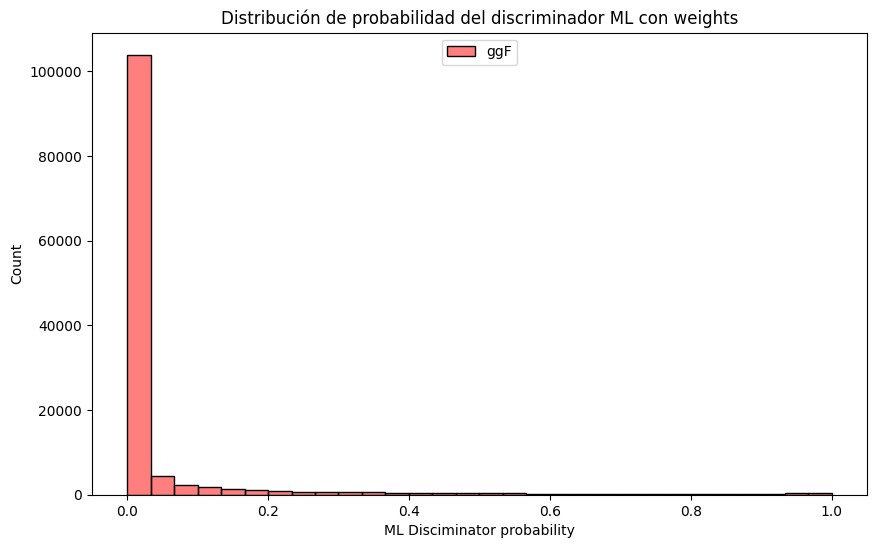

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data = X_ggf_vbf[X_ggf_vbf["tipo"] == "ggf"], x = "ML Disciminator probability", label="ggF", color="red", alpha=0.5, stat="count", bins=30, binrange=(0,1), weights="weights")
#sns.histplot(data = X_ggf_vbf[X_ggf_vbf["tipo"] == "vbf"], x = "ML Disciminator probability", label="VBF", color="blue", alpha=0.5, stat="count", bins=30, binrange=(0,1), weights="weights")
plt.legend(loc="upper center")
#plt.yscale("log")
plt.title("Distribución de probabilidad del discriminador ML con weights")

Text(0.5, 1.0, 'Distribución de probabilidad del discriminador ML con weights')

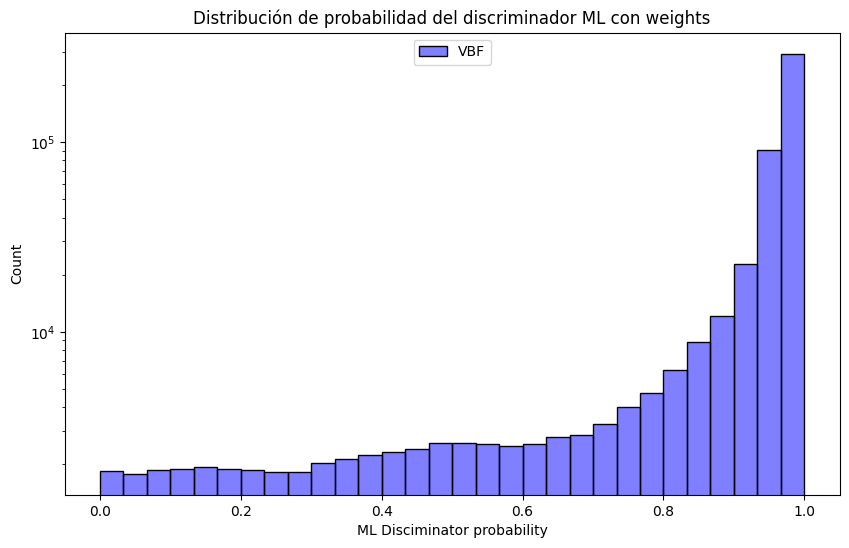

In [35]:
plt.figure(figsize=(10, 6))
#sns.histplot(data = X_ggf_vbf[X_ggf_vbf["tipo"] == "ggf"], x = "ML Disciminator probability", label="ggF", color="red", alpha=0.5, stat="count", bins=30, binrange=(0,1), weights="weights")
sns.histplot(data = X_ggf_vbf[X_ggf_vbf["tipo"] == "vbf"], x = "ML Disciminator probability", label="VBF", color="blue", alpha=0.5, stat="count", bins=30, binrange=(0,1))#, weights="weights")
plt.legend(loc="upper center")
plt.yscale("log")
plt.title("Distribución de probabilidad del discriminador ML con weights")

In [36]:
def get_significance_poisson(s, b):
    if b > 0:
        significance = math.sqrt(2 * abs( (s+b) * math.log(1 + ( s / b )) - s))
    else:
        significance = 0
    return significance

In [37]:
X_ggf_vbf

,mjj,njet30,detajj,dphijj,MET,scale1fb,intLumi,jet1_pt,jet1_eta,jet1_phi,jet1_e,signetajj,METsig,METOSqrtHT,weights,tipo,VBF label,ML Disciminator,ML Disciminator probability,label
2716432,-9.990000e+02,0,-999.000000,-999.000000,2122.894287,0.000054,58.450001,-999.000000,-999.000000,-999.000000,-9.990000e+02,-999.0,0.212289,-1.000000,0.003156,ggf,0,0,0.000856,NaN
2366463,-9.990000e+02,1,-999.000000,-999.000000,80834.273438,0.043821,36.099998,63617.238281,-1.498950,0.352606,1.496042e+05,-999.0,5.719438,8.810128,1.581932,ggf,0,0,0.000866,NaN
4064871,-9.990000e+02,0,-999.000000,-999.000000,22601.738281,0.028874,58.450001,-999.000000,-999.000000,-999.000000,-9.990000e+02,-999.0,1.885651,4.247137,1.687709,ggf,0,0,0.000856,0.0
2039855,-9.990000e+02,0,-999.000000,-999.000000,17035.644531,0.040857,44.299999,-999.000000,-999.000000,-999.000000,-9.990000e+02,-999.0,1.703565,-1.000000,1.809952,ggf,0,0,0.000856,0.0
1898441,-9.990000e+02,1,-999.000000,-999.000000,82792.968750,0.043821,36.099998,69868.562500,0.419248,-2.772874,7.726505e+04,-999.0,7.176879,7.316245,1.581932,ggf,0,0,0.000963,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628571,1.367926e+06,2,4.957650,0.648911,216401.265625,0.000256,36.099998,116440.851562,-3.211884,-1.108183,1.447791e+06,-1.0,9.050525,10.994148,0.009256,vbf,1,1,0.991920,NaN
4628572,1.540464e+06,3,5.033163,-0.568785,191440.421875,0.000305,36.099998,134930.218750,3.088001,3.006982,1.482836e+06,-1.0,8.956504,10.209519,0.011002,vbf,1,1,0.982350,NaN
4628573,1.694813e+06,2,5.825066,-2.918931,35132.878906,0.000271,1.000000,110081.000000,3.609008,-1.897832,2.034103e+06,-1.0,3.131326,2.310271,0.000271,vbf,1,1,0.983818,NaN
4628574,7.387971e+05,3,5.037199,0.789625,97912.656250,0.000282,36.099998,105132.671875,-0.351721,2.537084,1.122496e+05,-1.0,6.893644,8.417377,0.010165,vbf,1,1,0.981185,NaN


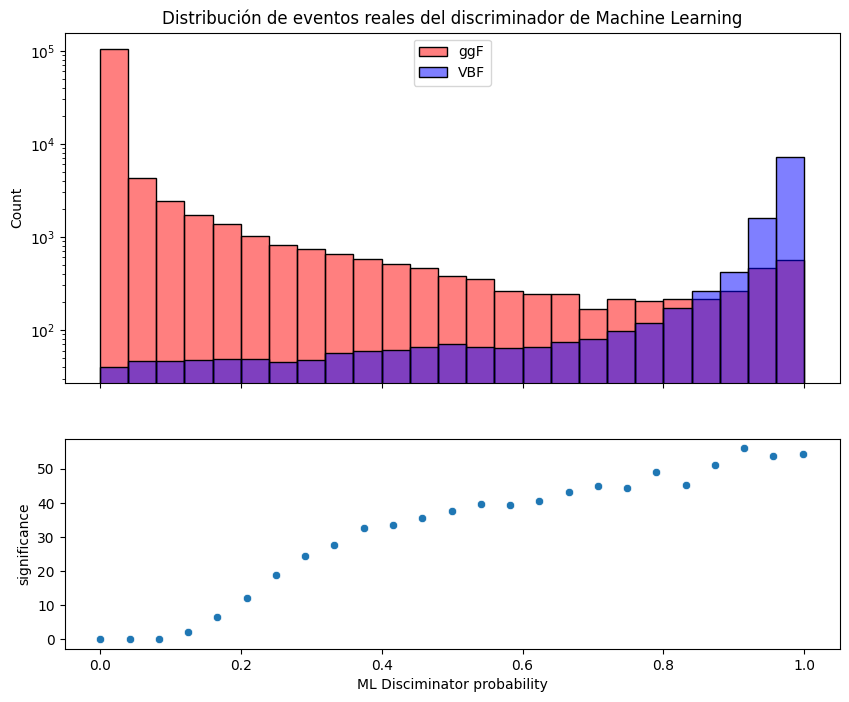

In [38]:
bins = 25
df_sign = X_ggf_vbf.copy().sort_values(by="ML Disciminator probability", ascending=True)
sgn_list = []

# Asumiendo que df_sign es tu DataFrame y bins es un entero positivo
num_rows = df_sign.shape[0]
edges = np.linspace(0, num_rows, bins+1, dtype=int)  # Crear índices de los bordes de los bins
 
for i in range(bins):
    start_idx = edges[i]     # Índice de inicio del bin actual
    end_idx = edges[i + 1]   # Índice final del bin actual

    # Utilizar .iloc para segmentar el DataFrame
    df_temp = df_sign.iloc[start_idx:end_idx]

    # Calcular las sumas de los pesos
    s = df_temp[df_temp["tipo"] == "vbf"]["weights"].sum()
    b = df_temp[df_temp["tipo"] == "ggf"]["weights"].sum()

    # Calcular la significancia
    significance = get_significance_poisson(s, b)

    # Añadir la significancia a la lista
    sgn_list.append(significance)

    
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [10, 6]}, sharex=True)
sns.histplot(data = X_ggf_vbf[X_ggf_vbf["tipo"] == "ggf"], x = "ML Disciminator probability", label="ggF", color="red", alpha=0.5, stat="count", bins=bins, binrange=(0,1), ax = axs[0], weights="weights")
sns.histplot(data = X_ggf_vbf[X_ggf_vbf["tipo"] == "vbf"], x = "ML Disciminator probability", label="VBF", color="blue", alpha=0.5, stat="count", bins=bins, binrange=(0,1), ax = axs[0], weights="weights")
sns.scatterplot(x = np.linspace(df_sign["ML Disciminator probability"].min(),df_sign["ML Disciminator probability"].max(),bins), y = sgn_list, ax = axs[1])
axs[0].legend(loc="upper center")
axs[0].set_yscale("log")
axs[0].set_title("Distribución de eventos reales del discriminador de Machine Learning")
axs[1].set_ylabel("significance")
axs[1].set_xlabel("ML Disciminator probability")
plt.show()

In [39]:
#X_ggf_vbf_completo["ML Disciminator probability"].plot(kind='density')

# Cortes

In [40]:
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.1) & ( X_ggf_vbf["tipo"] == 'vbf')]["weights"].sum())
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.1) & ( X_ggf_vbf["tipo"] == 'ggf')]["weights"].sum())

10800.525
12690.523


In [41]:
93.1-64.1

29.0

In [42]:
get_significance_gauss(3, 3)

1.2247448713915892

In [43]:
7991/701

11.399429386590585

In [44]:
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.85) & ( X_ggf_vbf["tipo"] == 'vbf')]["weights"].sum())
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.85) & ( X_ggf_vbf["tipo"] == 'ggf')]["weights"].sum())

9439.075
1468.6052


In [45]:
9450/1443

6.548856548856548

In [46]:
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf["tipo"] == 'vbf')]["weights"].sum())
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf["tipo"] == 'ggf')]["weights"].sum())

9920.103
2240.5005


In [47]:
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf["tipo"] == 'vbf')]["weights"].sum())
print(X_ggf_vbf[(X_ggf_vbf["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf["tipo"] == 'ggf')]["weights"].sum())

9920.103
2240.5005


In [48]:
9926.482 / 2219.3984


4.472600322682038

In [69]:
# Corte mjj > 900000
X_ggf_vbf_mjj_cut = X_ggf_vbf[(X_ggf_vbf["mjj"] > 1000000)]# & (X_ggf_vbf["njet30"] > 1)]

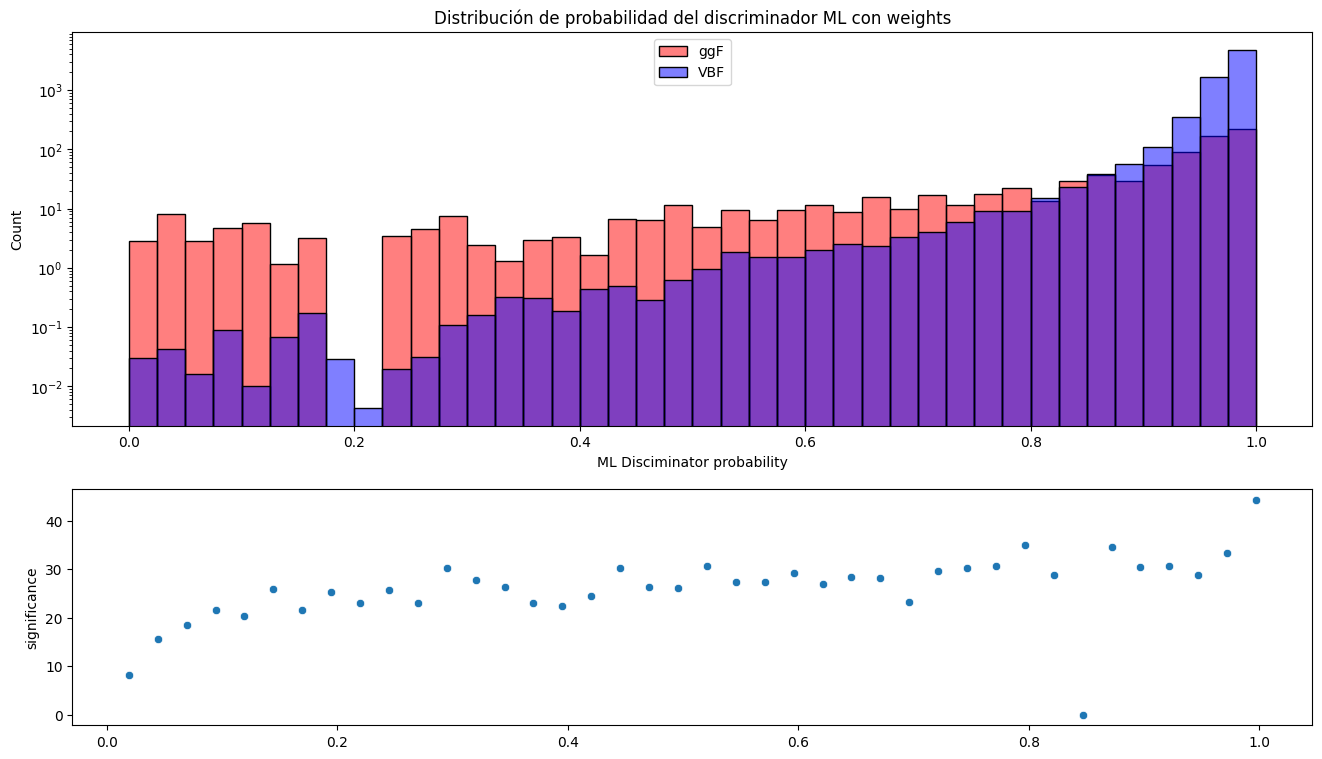

In [70]:
bins = 40
df_sign = X_ggf_vbf_mjj_cut.copy().sort_values(by="ML Disciminator probability", ascending=True)
sgn_list = []
for i in range(bins):
    df_temp = df_sign[round(df_sign.shape[0]/bins) *i : round(df_sign.shape[0]/bins) *(i+1)]
    s = df_temp[df_temp["tipo"] == "vbf"]["weights"].sum()
    b = df_temp[df_temp["tipo"] == "ggf"]["weights"].sum()
    significance = get_significance_poisson(s,b)
    sgn_list.append(significance)
    
fig, axs = plt.subplots(2, 1, figsize=(16, 9), gridspec_kw={'height_ratios': [10, 6]})
sns.histplot(data = X_ggf_vbf_mjj_cut[X_ggf_vbf_mjj_cut["tipo"] == "ggf"], x = "ML Disciminator probability", label="ggF", color="red", alpha=0.5, stat="count", bins=bins, binrange=(0,1), weights="weights", ax = axs[0])
sns.histplot(data = X_ggf_vbf_mjj_cut[X_ggf_vbf_mjj_cut["tipo"] == "vbf"], x = "ML Disciminator probability", label="VBF", color="blue", alpha=0.5, stat="count", bins=bins, binrange=(0,1), weights="weights", ax = axs[0])
sns.scatterplot(x = np.linspace(df_sign["ML Disciminator probability"].min(),df_sign["ML Disciminator probability"].max(),bins), y = sgn_list, ax = axs[1])
axs[0].legend(loc="upper center")
axs[0].set_yscale("log")
axs[0].set_title("Distribución de probabilidad del discriminador ML con weights")
axs[1].set_ylabel("significance")
plt.show()

In [71]:
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.95) & ( X_ggf_vbf_mjj_cut["tipo"] == 'vbf')]["weights"].sum())
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.95) & ( X_ggf_vbf_mjj_cut["tipo"] == 'ggf')]["weights"].sum())

6390.866
390.5689


In [72]:
6400/388

16.49484536082474

In [73]:
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.85) & ( X_ggf_vbf_mjj_cut["tipo"] == 'vbf')]["weights"].sum())
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.85) & ( X_ggf_vbf_mjj_cut["tipo"] == 'ggf')]["weights"].sum())

6943.847
601.5748


In [74]:
7939.4375/750.1964


10.58314529368576

In [75]:
6944/ 597

11.631490787269682

In [76]:
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf_mjj_cut["tipo"] == 'vbf')]["weights"].sum())
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf_mjj_cut["tipo"] == 'ggf')]["weights"].sum())

7010.0938
712.5832


In [77]:
7010 /  706


9.929178470254957

In [78]:
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf_mjj_cut["tipo"] == 'vbf')]["weights"].count())
print(X_ggf_vbf_mjj_cut[(X_ggf_vbf_mjj_cut["ML Disciminator probability"] >= 0.7) & ( X_ggf_vbf_mjj_cut["tipo"] == 'ggf')]["weights"].count())

313534
510
